# Getting Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from olist.data import Olist
from olist.order import Order
from olist.seller import Seller

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [3]:
#geting tables
orders = Order().get_training_data(with_distance_seller_customer=True).copy()
data = Olist().get_data().copy()
matching_table = Olist().get_matching_table().copy()
seller=Seller().get_training_data().copy()
order_review=data['order_reviews']
order_review=order_review.merge(matching_table[['order_id','seller_id']], how='left', on='order_id')

In [4]:
seller['cumm_costs_total']=seller['monthly_costs_total']*seller['months_of_sales']
seller['cumm_profit']=seller['sales']-seller['cumm_costs_total']
seller=seller.sort_values(by=['monthly_profit'], ascending=False)
sorted_sellers=seller.reset_index()

In [5]:
sorted_sellers['Tier']=0
sorted_sellers.loc[0:70,'Tier']='tier_1'
sorted_sellers.loc[sorted_sellers['monthly_profit']<0 , 'Tier']='tier_3'
sorted_sellers.loc[sorted_sellers['Tier']==0,'Tier']='tier_2'

# Explore

<AxesSubplot:xlabel='sales', ylabel='share_of_one_stars'>

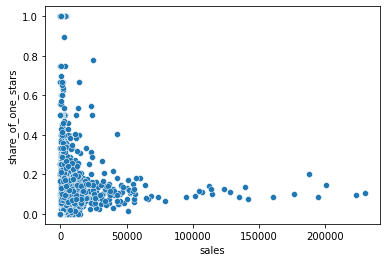

In [6]:
#investigate sales vs share of one star
sns.scatterplot(x=seller['sales'],y=seller['share_of_one_stars'])

# Contribution of each seller on profit

In [8]:
np.arange(0, 3000, step=100)

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900])

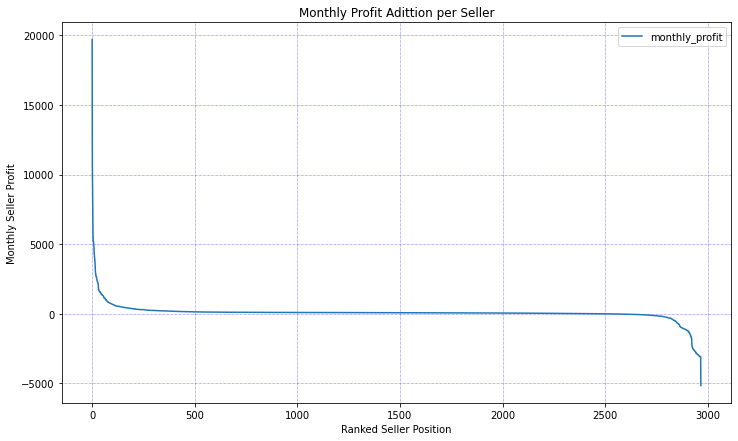

In [14]:
### Total Olist Profit

fig = plt.subplots(figsize=(12,7))
profit_seller= sns.lineplot(data=sorted_sellers[['monthly_profit']])
profit_seller.set(xlabel='Ranked Seller Position', ylabel='Monthly Seller Profit')
profit_seller.set_title('Monthly Profit Adittion per Seller')
profit_seller.grid(linestyle=':', linewidth='0.5', color='blue')

#profit_seller.annotate('Top 70 sellers', xy =(70, 1000),
#             xytext =(3, 1.8),
#             arrowprops = dict(facecolor ='green',
#                               shrink = 0.1),   )

#profit_seller.set_xticklabels(np.arange(0, 3000, step=100))
plt.show(profit_seller)

<font size="3">**We will split the sellers in 3 tiers:**<br />
**Tier 1**: top 70 sellers -> biggest contributors for profit<br />
**Tier 2**: positive profit sellers, individually not the biggest contributors but volume combined is high<br />
**Tier 3**: profit drainers. Sellers who didnt manage to deliver profit yet

In [276]:
sorted_sellers.columns

Index(['index', 'seller_id', 'seller_city', 'seller_state', 'delay_to_carrier',
       'wait_time', 'date_first_sale', 'date_last_sale', 'share_of_one_stars',
       'share_of_five_stars', 'share_of_four_stars', 'share_of_three_stars',
       'share_of_two_stars', 'review_score', 'n_orders', 'quantity',
       'quantity_per_order', 'sales', 'months_of_sales', 'monthly_sales',
       'month_integer', 'monthly_costs', 'monthly_costs_IT',
       'monthly_costs_total', 'monthly_profit', 'cumm_costs_total',
       'cumm_profit', 'Tier'],
      dtype='object')

<AxesSubplot:xlabel='share_of_one_stars', ylabel='delay_to_carrier'>

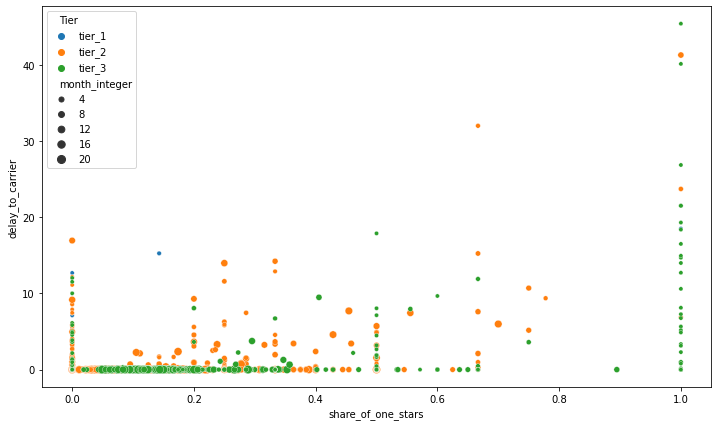

In [293]:
fig = plt.subplots(figsize=(12,7))
sns.scatterplot(data=sorted_sellers,x=sorted_sellers['share_of_one_stars'],y=sorted_sellers['delay_to_carrier'],hue='Tier',size='month_integer')

The graph above clearly suggests sellers that have 100% one stars are taking too long to post the customer order. At the same time, we see that sellers with 100% one stars are usually new sellers, less than 4 months at the platform


**Senior Sellers- more than 3 months in platform**

<AxesSubplot:xlabel='share_of_one_stars', ylabel='delay_to_carrier'>

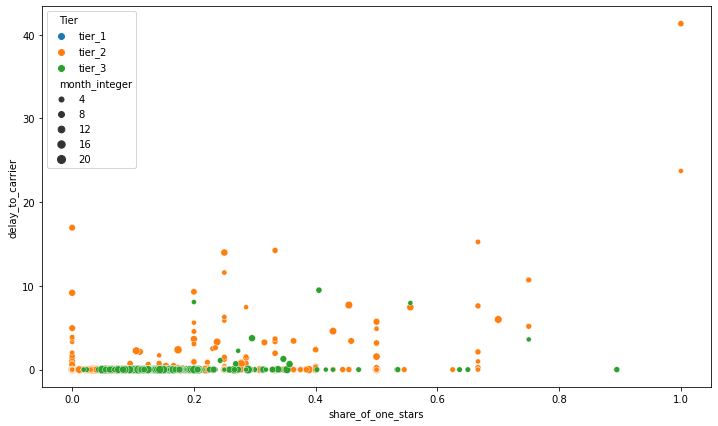

In [295]:
fig = plt.subplots(figsize=(12,7))
sns.scatterplot(data=sorted_sellers,x=sorted_sellers[sorted_sellers['month_integer']>3]['share_of_one_stars'],y=sorted_sellers['delay_to_carrier'],hue='Tier',size='month_integer')

# Tier 3: Profit Drainers - Let's Analyze the negative tail of the profit curve

In [272]:
negative_profit=sorted_sellers[sorted_sellers['cumm_profit']<0]

Text(0, 0.5, 'profit loss')

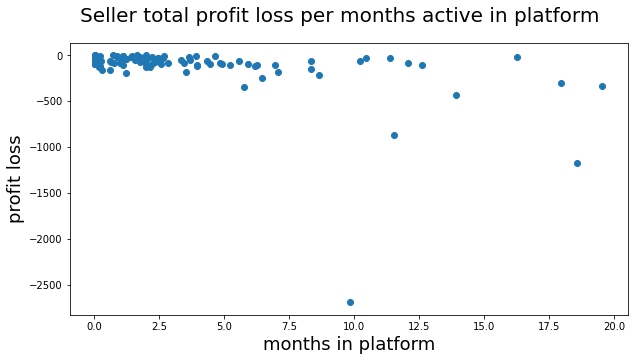

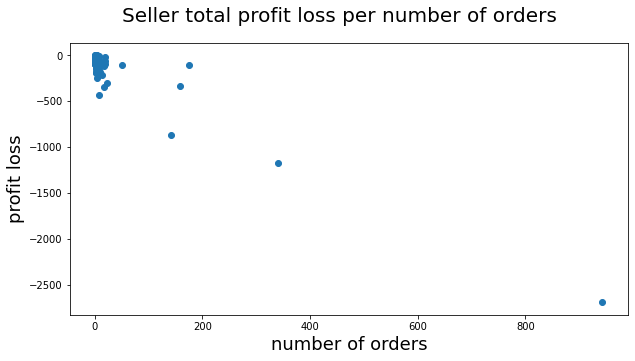

In [273]:
fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.scatter(negative_profit['months_of_sales'],negative_profit['cumm_profit'])
fig1.suptitle('Seller total profit loss per months active in platform', fontsize=20)
plt.xlabel('months in platform', fontsize=18)
plt.ylabel('profit loss', fontsize=18)


fig2, ax2 = plt.subplots(figsize=(10,5))
ax2.scatter(negative_profit['n_orders'],negative_profit['cumm_profit'])
fig2.suptitle('Seller total profit loss per number of orders', fontsize=20)
plt.xlabel('number of orders', fontsize=18)
plt.ylabel('profit loss', fontsize=18)

**Conclusion**: Sellers that have been in the platform for longer periods of time have higher loss than the newly joined in the platform.
We can call them "persistent profit drainers" meaning we dont believe they can improve their performance and will be excluded from sales platform.

**We define a forgiving period of 3 months so the newly joined seller can adapt and adjust their operation. After 3months, any operation that result in profit loss will be shut down.**

## Monthly loss of profit

In [274]:
tier_3=sorted_sellers[sorted_sellers['Tier']=='tier_3']
monthly_loss=tier_3['monthly_profit'].sum()
senior_sellers_tier_3=tier_3[tier_3['months_of_sales']>3]
new_sellers_tier_3=tier_3[tier_3['months_of_sales']<=3]
persis_loss_ratio=senior_sellers_tier_3['monthly_profit'].sum()/monthly_loss

<font size="5"> We have an average monthly loss of **253k** from the profit drainers sellers. By terminating the persistent ones, ie, the ones who have been in the platform for more than **3 months**, we will reduce by **40k** a month.
Its a **16%** reduction.

<font size="5">But we need to coach the remaining freshly new joiners so they don't become persistent profit drainers.

## Reviews os newly joined sellers

### code on reviews of new joiners

In [93]:
new_seller_list=new_sellers_tier_3['seller_id'].tolist()
boolean_series = order_review.seller_id.isin(new_seller_list)
review_neg_sellers=order_review[boolean_series]

In [227]:
pd.options.display.max_colwidth=300
#review_neg_sellers[review_neg_sellers['review_score']<3][['review_comment_message']].dropna().tail(60)

In [150]:
review_neg_sellers['cancel']=review_neg_sellers['review_comment_message'].str.contains("cancel", case=False)
review_neg_sellers['different']=review_neg_sellers['review_comment_message'].str.contains("errad|difere|veio outro|veio outra", case=False)
review_neg_sellers['delay']=review_neg_sellers['review_comment_message'].str.contains("demora|atras", case=False)
review_neg_sellers['never arrived']=review_neg_sellers['review_comment_message'].str.contains("não receb|não chegou|nao receb|nao chegou|não entreg|nao entreg|nao foi entreg|não foi entreg", case=False)
review_neg_sellers['counterfeit']=review_neg_sellers['review_comment_message'].str.contains("original|falso|falsificado", case=False)
review_neg_sellers['incomplete']=review_neg_sellers['review_comment_message'].str.contains("incomplet|imcomplet|recebi apenas|faltando|chegou apenas|só recebi|so recebi", case=False)

/tmp/ipykernel_8508/3217303109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_neg_sellers['cancel']=review_neg_sellers['review_comment_message'].str.contains("cancel", case=False)
/tmp/ipykernel_8508/3217303109.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_neg_sellers['different']=review_neg_sellers['review_comment_message'].str.contains("errad|difere|veio outro|veio outra", case=False)
/tmp/ipykernel_8508/3217303109.py:3: SettingWithCopyWarning: 
A value is trying to be set on a co

In [151]:
perc_cancel=review_neg_sellers[review_neg_sellers['review_score']<3]['cancel'].sum()/review_neg_sellers[review_neg_sellers['review_score']<3].shape[0]
perc_diff=review_neg_sellers[review_neg_sellers['review_score']<3]['different'].sum()/review_neg_sellers[review_neg_sellers['review_score']<3].shape[0]
perc_never_arrived=review_neg_sellers[review_neg_sellers['review_score']<3]['never arrived'].sum()/review_neg_sellers[review_neg_sellers['review_score']<3].shape[0]
perc_counterfeit=review_neg_sellers[review_neg_sellers['review_score']<3]['counterfeit'].sum()/review_neg_sellers[review_neg_sellers['review_score']<3].shape[0]
perc_delay=review_neg_sellers[review_neg_sellers['review_score']<3]['delay'].sum()/review_neg_sellers[review_neg_sellers['review_score']<3].shape[0]
perc_incomplete=review_neg_sellers[review_neg_sellers['review_score']<3]['incomplete'].sum()/review_neg_sellers[review_neg_sellers['review_score']<3].shape[0]

### Breakdown of root cause on bad reviews of new sellers

In [200]:
print(f"Orders that never arrived: {int(perc_never_arrived*100)}% \nOrders canceled: {int(perc_cancel*100)}% \nOrders delayed: {int(perc_delay*100)}% \nWrong goods received: {int(perc_diff*100)}% \nGoods are counterfeit: {int(perc_counterfeit*100)}% \nOrder received incomplete:{int(perc_incomplete*100)}%")

Orders that never arrived: 21% 
Orders canceled: 3% 
Orders delayed: 6% 
Wrong goods received: 6% 
Goods are counterfeit: 2% 
Order received incomplete:9%


## "Orders that never arrived" corresponde to 21% of bad reviews.


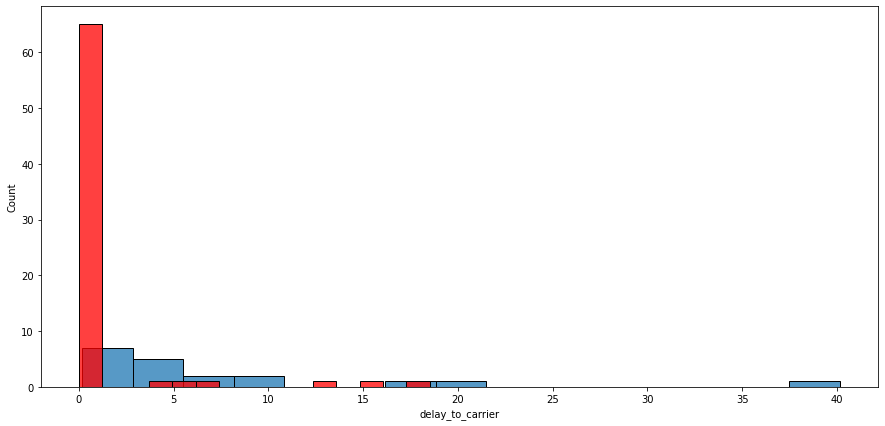

<Figure size 1080x504 with 0 Axes>

In [240]:
seller_never_arrived=review_neg_sellers[review_neg_sellers['never arrived']==True]['seller_id'].tolist()
boolean_series = new_sellers_tier_3.seller_id.isin(seller_never_arrived)
plt.figure(figsize=(15,7))
sns.histplot(new_sellers_tier_3[boolean_series][new_sellers_tier_3[boolean_series]['delay_to_carrier']>0]['delay_to_carrier'],bins=15)
sns.histplot(tier_1['delay_to_carrier'],color='red',bins=15)
plt.figure(figsize=(15,7))
plt.show()

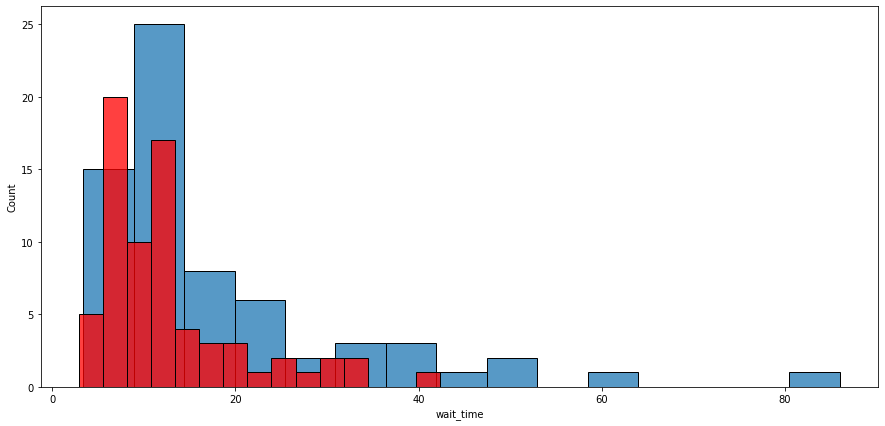

In [241]:
seller_never_arrived=review_neg_sellers[review_neg_sellers['never arrived']==True]['seller_id'].tolist()
boolean_series = new_sellers_tier_3.seller_id.isin(seller_never_arrived)
plt.figure(figsize=(15,7))
sns.histplot(new_sellers_tier_3[boolean_series][new_sellers_tier_3[boolean_series]['wait_time']>0]['wait_time'],bins=15)
sns.histplot(tier_1['wait_time'],color='red',bins=15)
plt.show()

For new sellers, we can see that there's a delay on posting the order compared to high performance sellers. It seems the new, unexperienced sellers are taking too long to post the orders or even not posting at all and dont communicate with the buyer.
To avoid or minimize this problem we suggest:

**Recommendation:**<br /> a. playbook for new sellers. Advising to prepare goods in advance, post to carrier during first 5 days.<br />
                b. option to buyer to cancel the transaction if delay is more than 15 days for example.<br />
                c. make it obligatory for the seller to send an explanation, a message to buyer in case of delay > 15 days

# Tier 2

In [302]:
sorted_sellers.columns

Index(['index', 'seller_id', 'seller_city', 'seller_state', 'delay_to_carrier',
       'wait_time', 'date_first_sale', 'date_last_sale', 'share_of_one_stars',
       'share_of_five_stars', 'share_of_four_stars', 'share_of_three_stars',
       'share_of_two_stars', 'review_score', 'n_orders', 'quantity',
       'quantity_per_order', 'sales', 'months_of_sales', 'monthly_sales',
       'month_integer', 'monthly_costs', 'monthly_costs_IT',
       'monthly_costs_total', 'monthly_profit', 'cumm_costs_total',
       'cumm_profit', 'Tier'],
      dtype='object')

<AxesSubplot:xlabel='share_of_one_stars', ylabel='sales'>

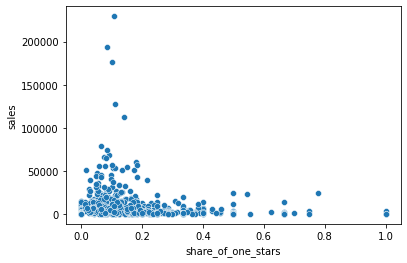

In [304]:
sorted_sellers[sorted_sellers['Tier']=='tier_2']
sns.scatterplot(x=sorted_sellers[sorted_sellers['Tier']=='tier_2']['share_of_one_stars'],y=sorted_sellers[sorted_sellers['Tier']=='tier_2']['sales'])

<AxesSubplot:xlabel='delay_to_carrier', ylabel='Count'>

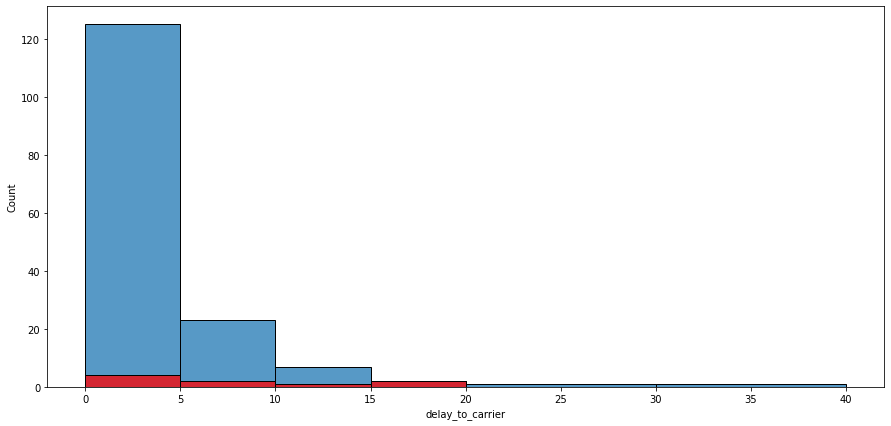

In [332]:
bins=[0,5,10,15,20,30,40]
plt.figure(figsize=(15,7))
sns.histplot(tier_2[tier_2['delay_to_carrier']>0]['delay_to_carrier'],bins=bins)
sns.histplot(tier_1[tier_1['delay_to_carrier']>0]['delay_to_carrier'],color='red',bins=bins)

In [337]:
tier1_2=sorted_sellers[sorted_sellers['Tier']!='tier_3']

In [340]:
sorted_sellers.columns

Index(['index', 'seller_id', 'seller_city', 'seller_state', 'delay_to_carrier',
       'wait_time', 'date_first_sale', 'date_last_sale', 'share_of_one_stars',
       'share_of_five_stars', 'share_of_four_stars', 'share_of_three_stars',
       'share_of_two_stars', 'review_score', 'n_orders', 'quantity',
       'quantity_per_order', 'sales', 'months_of_sales', 'monthly_sales',
       'month_integer', 'monthly_costs', 'monthly_costs_IT',
       'monthly_costs_total', 'monthly_profit', 'cumm_costs_total',
       'cumm_profit', 'Tier'],
      dtype='object')

<AxesSubplot:xlabel='delay_to_carrier', ylabel='monthly_profit'>

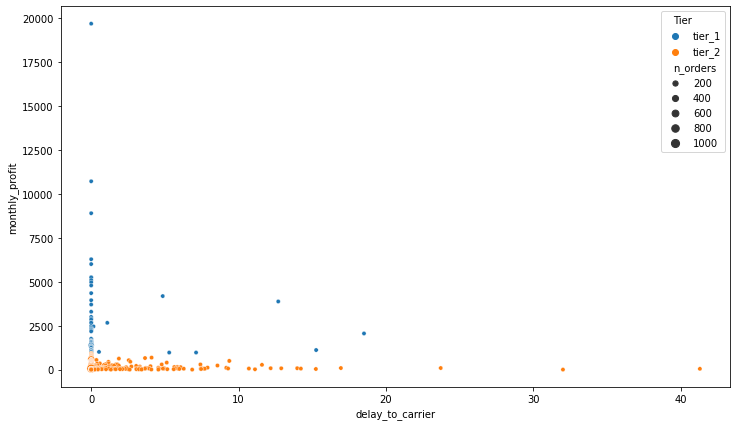

In [342]:
fig = plt.subplots(figsize=(12,7))
sns.scatterplot(data=tier1_2,x=tier1_2['delay_to_carrier'],y=tier1_2['monthly_profit'],hue='Tier',size='n_orders')

<AxesSubplot:xlabel='monthly_costs_total', ylabel='monthly_profit'>

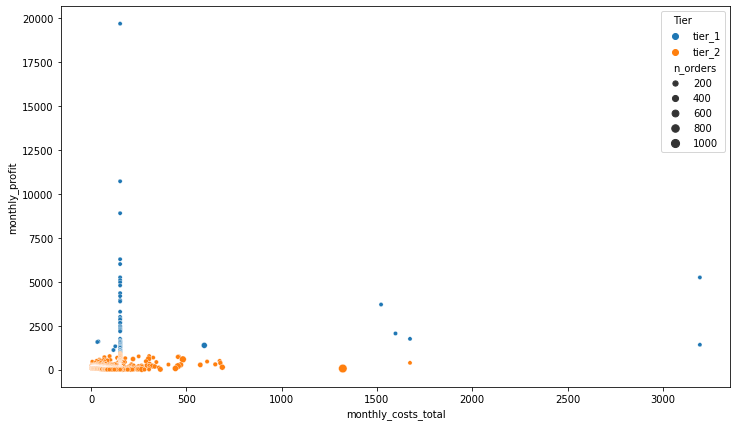

In [368]:
fig = plt.subplots(figsize=(12,7))
sns.scatterplot(data=tier1_2,x=tier1_2['monthly_costs_total'],y=tier1_2['monthly_profit'],hue='Tier',size='n_orders')

It seems for tier 2 sellers gives much higher costs to OLIST than tier 1 sellers. So in order to improve OLIST P&L we need to reduce Tier2 costs.

Reminding that costs are directly linked to amounts of one and two stars reviews.

For Tier 2, 52% of sellers have at least 1 star review, versus 7% from Tier1
            28% of sellers have at least 2 star review, versus 4% from Tier1

In [365]:
perc_tier1_1star=sorted_sellers[sorted_sellers['Tier']=='tier_1'][sorted_sellers[sorted_sellers['Tier']=='tier_1']['share_of_one_stars']>0]['share_of_one_stars'].count()/sorted_sellers[sorted_sellers['Tier']=='tier_1']['share_of_one_stars'].count()
perc_tier2_1star=sorted_sellers[sorted_sellers['Tier']=='tier_2'][sorted_sellers[sorted_sellers['Tier']=='tier_2']['share_of_one_stars']>0]['share_of_one_stars'].count()/sorted_sellers[sorted_sellers['Tier']=='tier_2']['share_of_one_stars'].count()

In [366]:
perc_tier1_2star=sorted_sellers[sorted_sellers['Tier']=='tier_1'][sorted_sellers[sorted_sellers['Tier']=='tier_1']['share_of_two_stars']>0]['share_of_two_stars'].count()/sorted_sellers[sorted_sellers['Tier']=='tier_1']['share_of_two_stars'].count()
perc_tier2_2star=sorted_sellers[sorted_sellers['Tier']=='tier_2'][sorted_sellers[sorted_sellers['Tier']=='tier_2']['share_of_two_stars']>0]['share_of_two_stars'].count()/sorted_sellers[sorted_sellers['Tier']=='tier_2']['share_of_two_stars'].count()

## Investigate why there's so much 1 and 2 star review in Tier 2:

<AxesSubplot:xlabel='monthly_costs_total', ylabel='delay_to_carrier'>

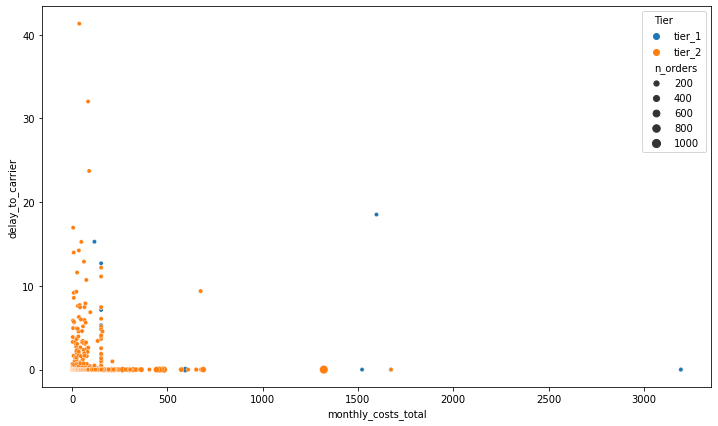

In [370]:
fig = plt.subplots(figsize=(12,7))
sns.scatterplot(data=tier1_2,x=tier1_2['monthly_costs_total'],y=tier1_2['delay_to_carrier'],hue='Tier',size='n_orders')

It doesnt seem to be related to delay to carrier. We would expect to see a straight line. But thats not the case

# Tier 1

<AxesSubplot:xlabel='share_of_two_stars', ylabel='sales'>

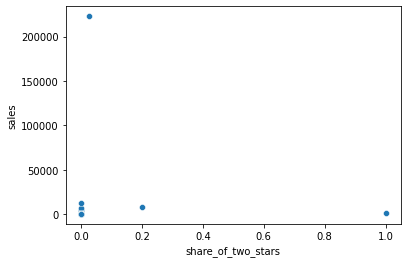

In [307]:
sns.scatterplot(x=sorted_sellers[sorted_sellers['Tier']=='tier_1']['share_of_two_stars'],y=sorted_sellers[sorted_sellers['Tier']=='tier_1']['sales'])

# Summary of Actions to improve OLIST P&L:

In [321]:
tier_1[tier_1['delay_to_carrier']>0]['delay_to_carrier'].mean()

7.281227494855967

In [322]:
tier_2[tier_2['delay_to_carrier']>0]['delay_to_carrier'].mean()

3.600362349035241

In [323]:
tier_3[tier_3['delay_to_carrier']>0]['delay_to_carrier'].mean()

7.0787825205274695

In [324]:
new_sellers_tier_3['monthly_profit'].sum()*0.25

-53174.71800191776

**-> Sellers Removal:**<br />
    Remove profit drainer sellers which are in the platform for more than 3 months<br />
    Estimation to gain monthly ***40k*** in p&l<br />

**->  Sellers improvement program:**<br />
    Train or implement features with goal of max 15 days of shipping to carrier.<br />
    target group: on new joiners sellers, on tier 2 sellers-> goal to convert them to tier1 sellers.<br />
    Estimation to gain monthly: 53k